The image registration process implemented utilizes SimpleITK to align a moving image to a fixed reference image through an iterative optimization framework.  
The registration employs a Mattes Mutual Information metric, which quantifies the statistical dependence between the intensity distributions of the two images, making it particularly effective for multimodal image registration.  

It also outputs a tif file where each slice is the mutual information joint histogram at a specific iteration of the registration process.  
Each histogram visualizes the distribution and correlation of intensity values between the fixed and moving images at that iteration, with color intensity representing the frequency of intensity co-occurrences.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from scipy.stats import entropy
import tifffile
from typing import Tuple, List
import logging
from scipy.ndimage import zoom

In [2]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler()
    ]
)

In [3]:
def normalize_image(img: np.ndarray) -> np.ndarray:

    img_min = np.min(img)
    img_max = np.max(img)
    if img_max > img_min:
        img_normalized = (img - img_min) / (img_max - img_min)
    else:
        img_normalized = np.zeros_like(img)
    img_uint8 = (img_normalized * 255).astype(np.uint8)
    return img_uint8


def show_images(fixed: np.ndarray, moving: np.ndarray, title: str = "") -> None:

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(fixed, cmap="gray")
    axes[0].set_title("Fixed Image")
    axes[1].imshow(moving, cmap="gray")
    axes[1].set_title("Moving Image")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [4]:
def resize_image(img: np.ndarray, target_height: int) -> np.ndarray:

    original_height, original_width = img.shape[:2]
    scale_factor = target_height / original_height
    target_width = int(original_width * scale_factor)
    
    if len(img.shape) == 3:
        # RGB image
        resized_img = zoom(img, (scale_factor, scale_factor, 1), order=1)
    else:
        # Grayscale image
        resized_img = zoom(img, (scale_factor, scale_factor), order=1)
    
    # Ensure the resized image has the exact target height
    resized_img = resized_img[:target_height, :target_width]
    
    return resized_img.astype(np.uint8)

In [5]:
def compute_mutual_information(fixed: np.ndarray, moving: np.ndarray, iteration: int = None, bins: int = 50) -> Tuple[float, np.ndarray]:

    # Compute joint histogram
    hist_2d, x_edges, y_edges = np.histogram2d(fixed.ravel(), moving.ravel(), bins=bins)
    
    # Normalize to get joint probabilities
    pxy = hist_2d / np.sum(hist_2d)
    
    # Marginal probabilities
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    
    # Entropies
    Hx = entropy(px)
    Hy = entropy(py)
    Hxy = entropy(pxy.ravel())
    
    # Mutual Information
    mutual_info = Hx + Hy - Hxy
    
    # Create joint histogram plot with RGB colormap
    fig, ax = plt.subplots(figsize=(4, 4))
    cax = ax.imshow(hist_2d.T, origin='lower', cmap='hot', aspect='auto')
    if iteration is not None:
        ax.set_title(f'Iteration: {iteration}\nMutual Information: {mutual_info:.4f}')
    else:
        ax.set_title(f'Mutual Information: {mutual_info:.4f}')
    ax.set_xlabel('Fixed Image Intensity')
    ax.set_ylabel('Moving Image Intensity')
    fig.colorbar(cax, label='Joint Histogram Count')
    
    # Render the plot to a NumPy array using buffer_rgba
    fig.canvas.draw()
    mi_image_rgba = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    mi_image_rgba = mi_image_rgba.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    plt.close(fig)
    
    # Convert RGBA to RGB by discarding the alpha channel
    mi_image = mi_image_rgba[..., :3]
    
    return mutual_info, mi_image

In [6]:
def combine_visualizations(fixed_img: np.ndarray, moving_img: np.ndarray, mi_img: np.ndarray) -> np.ndarray:

    # Normalize and convert grayscale images to uint8
    fixed_uint8 = normalize_image(fixed_img)
    moving_uint8 = normalize_image(moving_img)
    
    # Convert grayscale to RGB by stacking
    fixed_rgb = np.stack([fixed_uint8]*3, axis=-1)
    moving_rgb = np.stack([moving_uint8]*3, axis=-1)
    
    # Resize images to a smaller height for reduced resolution
    target_height = 300  # Example target height for smaller resolution
    fixed_resized = resize_image(fixed_rgb, target_height)
    moving_resized = resize_image(moving_rgb, target_height)
    mi_resized = resize_image(mi_img, target_height)
    
    # Ensure all images have the same height
    if mi_resized.shape[0] != target_height:
        # If resizing didn't achieve the exact target height, pad the image
        pad_height = target_height - mi_resized.shape[0]
        if pad_height > 0:
            mi_resized = np.pad(mi_resized, ((0, pad_height), (0,0), (0,0)), mode='constant', constant_values=0)
        else:
            mi_resized = mi_resized[:target_height, :, :]
    
    # Concatenate images horizontally
    combined_img = np.concatenate((fixed_resized, moving_resized, mi_resized), axis=1)
    
    return combined_img

In [7]:
class RegistrationIterationCallback:
    """
    Callback class to monitor and record mutual information during registration iterations.
    """
    
    def __init__(
        self,
        fixed_image: sitk.Image,
        moving_image: sitk.Image,
        initial_transform: sitk.Transform,
        registration_method: sitk.ImageRegistrationMethod,
        save_every: int = 1
    ):
        """
        Initialize the callback with necessary references.
        
        Parameters:
        - fixed_image (sitk.Image): Fixed image.
        - moving_image (sitk.Image): Moving image.
        - initial_transform (sitk.Transform): Initial transform.
        - registration_method (sitk.ImageRegistrationMethod): Registration method instance.
        - save_every (int): Interval of iterations to save combined images.
        """
        self.fixed = fixed_image
        self.moving = moving_image
        self.initial_transform = initial_transform
        self.registration_method = registration_method
        self.combined_images: List[np.ndarray] = []
        self.save_every = save_every  # Save combined image every 'save_every' iterations
        self.total_iterations = 0    # Global iteration counter
    
    def __call__(self) -> None:
        """
        Invoked at each registration iteration.
        """
        try:
            # Get current optimizer parameters
            current_parameters = self.registration_method.GetOptimizerPosition()
        except AttributeError:
            logging.error("Unable to retrieve optimizer position.")
            return

        # Increment global iteration counter
        self.total_iterations += 1

        if self.total_iterations % self.save_every != 0:
            # Skip saving for this iteration
            return

        # Create a new transform instance based on the initial transform's type
        transform_type = type(self.initial_transform)
        current_transform = transform_type()

        # Set fixed parameters (e.g., center of rotation)
        current_transform.SetFixedParameters(self.initial_transform.GetFixedParameters())

        # Set moving parameters (e.g., rotation angle, translations)
        current_transform.SetParameters(tuple(current_parameters))

        # Resample the moving image with the updated transform
        moving_resampled = sitk.Resample(
            self.moving,
            self.fixed,
            current_transform,
            sitk.sitkLinear,
            0.0,
            self.moving.GetPixelID()
        )

        # Convert images to NumPy arrays
        fixed_array = sitk.GetArrayFromImage(self.fixed)
        moving_resampled_array = sitk.GetArrayFromImage(moving_resampled)

        # Compute mutual information and get MI image
        mutual_info, mi_image = compute_mutual_information(fixed_array, moving_resampled_array, iteration=self.total_iterations)

        # Combine fixed, moving, and MI images into one visualization
        combined_img = combine_visualizations(fixed_array, moving_resampled_array, mi_image)

        # Append the combined image to the list
        self.combined_images.append(combined_img)

        # Log iteration details with global count
        metric_value = self.registration_method.GetMetricValue()
        logging.info(f"Global Iteration: {self.total_iterations}, "
                     f"Metric Value: {metric_value:.4f}, "
                     f"Mutual Information: {mutual_info:.4f}")

In [8]:
def perform_registration(
    fixed_image_path: str,
    moving_image_path: str,
    output_tiff_path: str,
    num_iterations: int = 200,
    bins: int = 50,
    save_every: int = 1
) -> sitk.Transform:

    # Read images
    fixed_image = sitk.ReadImage(fixed_image_path, sitk.sitkFloat32)
    moving_image = sitk.ReadImage(moving_image_path, sitk.sitkFloat32)

    # Initial display of the images
    fixed_array = sitk.GetArrayFromImage(fixed_image)
    moving_array = sitk.GetArrayFromImage(moving_image)
    show_images(fixed_array, moving_array, title="Before Registration")

    # Set up the registration framework
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric: Mattes Mutual Information
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=bins)

    # Optimizer settings
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=1.0,
        numberOfIterations=num_iterations,
        convergenceMinimumValue=1e-6,
        convergenceWindowSize=10
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Set the interpolator
    registration_method.SetInterpolator(sitk.sitkLinear)

    # Set up the initial transform (Euler 2D)
    initial_transform = sitk.CenteredTransformInitializer(
        fixed_image,
        moving_image,
        sitk.Euler2DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )

    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # Multi-resolution framework
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Initialize and add the callback
    callback = RegistrationIterationCallback(
        fixed_image,
        moving_image,
        initial_transform,
        registration_method,
        save_every=save_every
    )
    registration_method.AddCommand(sitk.sitkIterationEvent, callback)

    # Execute the registration
    try:
        final_transform = registration_method.Execute(
            sitk.Cast(fixed_image, sitk.sitkFloat32),
            sitk.Cast(moving_image, sitk.sitkFloat32)
        )
    except RuntimeError as e:
        logging.error(f"Registration failed: {e}")
        raise e

    # Apply the final transform to the moving image
    moving_resampled = sitk.Resample(
        moving_image,
        fixed_image,
        final_transform,
        sitk.sitkLinear,
        0.0,
        moving_image.GetPixelID()
    )

    # Convert resampled image to NumPy array for display
    moving_resampled_array = sitk.GetArrayFromImage(moving_resampled)
    show_images(fixed_array, moving_resampled_array, title="After Registration")

    # Print the final transform parameters
    logging.info(f"Final transform parameters: {final_transform}")

    # Save the combined images as a TIFF stack using tifffile
    if callback.combined_images:
        # Stack images along the first axis (pages)
        combined_stack = np.stack(callback.combined_images, axis=0)
        # Save as multi-page TIFF with RGB photometric interpretation
        tifffile.imwrite(output_tiff_path, combined_stack, photometric='rgb')
        logging.info(f"Combined visualizations saved as {output_tiff_path}")
    else:
        logging.warning("No combined images were captured during registration.")

    return final_transform

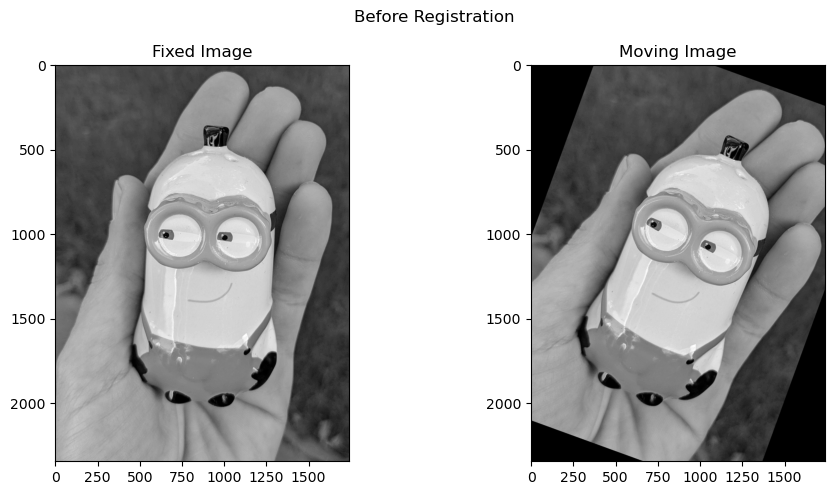

2024-09-22 20:27:16,691 - INFO - Global Iteration: 1, Metric Value: -0.5017, Mutual Information: 0.5193
2024-09-22 20:27:17,174 - INFO - Global Iteration: 2, Metric Value: -0.5035, Mutual Information: 0.5212
2024-09-22 20:27:17,634 - INFO - Global Iteration: 3, Metric Value: -0.5046, Mutual Information: 0.5225
2024-09-22 20:27:18,105 - INFO - Global Iteration: 4, Metric Value: -0.5058, Mutual Information: 0.5249
2024-09-22 20:27:18,555 - INFO - Global Iteration: 5, Metric Value: -0.5073, Mutual Information: 0.5260
2024-09-22 20:27:19,122 - INFO - Global Iteration: 6, Metric Value: -0.5085, Mutual Information: 0.5275
2024-09-22 20:27:19,578 - INFO - Global Iteration: 7, Metric Value: -0.5097, Mutual Information: 0.5288
2024-09-22 20:27:20,070 - INFO - Global Iteration: 8, Metric Value: -0.5107, Mutual Information: 0.5297
2024-09-22 20:27:20,546 - INFO - Global Iteration: 9, Metric Value: -0.5118, Mutual Information: 0.5309
2024-09-22 20:27:21,019 - INFO - Global Iteration: 10, Metric Va

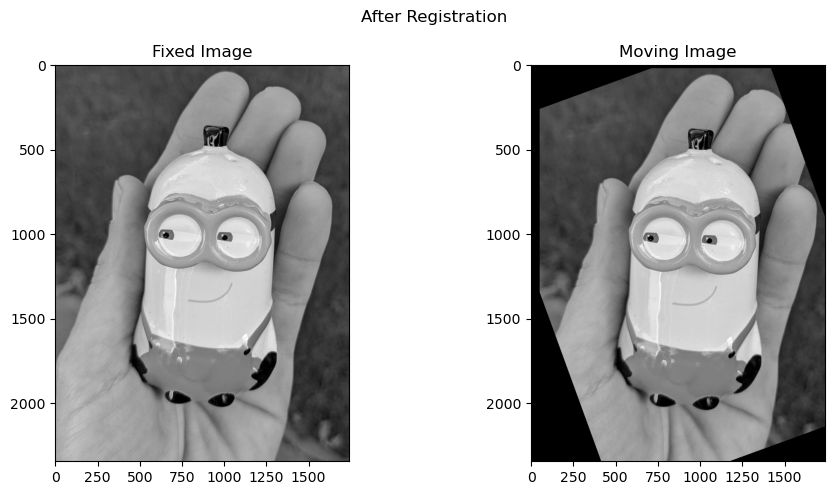

2024-09-22 20:28:33,789 - INFO - Final transform parameters: itk::simple::CompositeTransform
 CompositeTransform (0x55e39c0a7220)
   RTTI typeinfo:   itk::CompositeTransform<double, 2u>
   Reference Count: 1
   Modified Time: 28136
   Debug: Off
   Object Name: 
   Observers: 
     none
   TransformQueue: 
   >>>>>>>>>
   Euler2DTransform (0x55e3968135e0)
     RTTI typeinfo:   itk::Euler2DTransform<double>
     Reference Count: 1
     Modified Time: 27929
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.939612 -0.342241 
       0.342241 0.939612 
     Offset: [411.814, -261.629]
     Center: [869.5, 1171.5]
     Translation: [-41.6284, -34.7949]
     Inverse: 
       0.939612 0.342241 
       -0.342241 0.939612 
     Singular: 0
     Angle: 0.349301
   TransformsToOptimizeFlags: 
           1 
   TransformsToOptimizeQueue: 
   PreviousTransformsToOptimizeUpdateTime: 0

2024-09-22 20:28:33,924 - INFO - Combined visualizations saved as ../static/img/

In [9]:
# Define image paths (replace with your actual paths)
fixed_image_path = "kevin.jpg"
moving_image_path = "kevin-rotated-20.jpg"

# Define output path for the TIFF stack
output_tiff_path = os.path.expanduser("../static/img/joint_histogram_iterations.tif")

# Perform registration
final_transform = perform_registration(
    fixed_image_path=fixed_image_path,
    moving_image_path=moving_image_path,
    output_tiff_path=output_tiff_path,
    num_iterations=200,
    bins=50,
    save_every=1  # Change to >1 to save combined images less frequently
)
